In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data.load_from_csv import get_content_datasets
import pandas as pd
import theano
from datetime import datetime
from src.models.baselines.baseline_utils import run_baseline
import pymc3 as pm

% matplotlib inline

/Users/zac/miniconda3/envs/psj/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Hierarchical linear model of responses to questions

This notebook contains a hierarchical linear model of responses over time. For each question the responses are pooled across users, so user identity is lost. Although this is clearly suboptimal, our attempts so far to make use of user identity have not succeeded. Additionally, we don't attempt to learn a covariance between slope and intercept; both are allowed to vary freely. I have tried introducing this and it decreases predictive performance.

The model is as follows:

Hyperprior:

$$
\begin{align}
\rho_{\alpha}&\sim\mathcal{N}(0.5, 2) \\
\omega_{\alpha}&\sim\textrm{HalfCauchy}(2) \\
\rho_{\beta}&\sim\mathcal{N}(0.5, 2) \\
\omega_{\beta}&\sim\textrm{HalfCauchy}(2) \\
\epsilon&\sim\textrm{HalfCauchy}(0.5)
\end{align}
$$


Question-level (for each question $q_{i}$):

$$
\begin{align}
\alpha_{i}&\sim\mathcal{N}(\rho_{\alpha},\omega_{\alpha}) \\
\beta_{i}&\sim\mathcal{N}(\rho_{\beta},\omega_{\beta})
\end{align}
$$


Observation model (linear regression with intercept $\alpha$ and slope $\beta$):

$$
y_{t}\sim\mathcal{N}(\alpha + \beta t, \epsilon)
$$

## Load and process dataset

In [3]:
datasets = get_content_datasets(task='fermi', sparsity='unmasked')
train_dataset, val_dataset, test_dataset = datasets

In [4]:
def make_df(dataset):
    users = []
    questions = []
    times = []
    opinions = []

    for datum in dataset:
        for i, rating in enumerate(datum['rating']):
            if not np.isnan(rating):
                users.append(datum['user_id'])
                questions.append(datum['item_id'])
                times.append(i)
                opinions.append(rating)

    data = pd.DataFrame(data={'user':users,
                            'question': questions,
                            'time': times,
                            'opinion': opinions})
    
    return data

In [5]:
data = make_df(train_dataset)
val_data = make_df(val_dataset)
test_data = make_df(test_dataset)
question_ids = data.question.unique()
question_idx = data['question'].values

## Define and sample simple hierarchical linear model

In [6]:
param_len = max(np.concatenate([data.question.unique(), val_data.question.unique()]))+1
with pm.Model() as hierarchical_model:
    ## Top level hyperpriors
    rho_a = pm.Normal('rho_a', mu=0.5, sd=2.)
    omega_a = pm.HalfCauchy('omega_a', beta=2.)
    rho_b = pm.Normal('rho_b', mu=0., sd=2.)
    omega_b = pm.HalfCauchy('omega_b', beta=2.)
    
    ## Question level hyperpriors
    a = pm.Normal('alpha', mu=rho_a, sd=omega_a, shape=param_len)
    b = pm.Normal('beta', mu=rho_b, sd=omega_b, shape=param_len)
    
    eps = pm.HalfCauchy('eps', beta=0.5)
    opinion_est = a[question_idx] + b[question_idx] * data.time.values
    
    y_like = pm.Normal('y_like', mu=opinion_est, sd=eps, observed=data.opinion)
    
    trace = pm.sample(100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, beta, alpha, omega_b_log__, rho_b, omega_a_log__, rho_a]
The acceptance probability does not match the target. It is 0.9449954620658936, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9517394237473361, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


## Traceplot

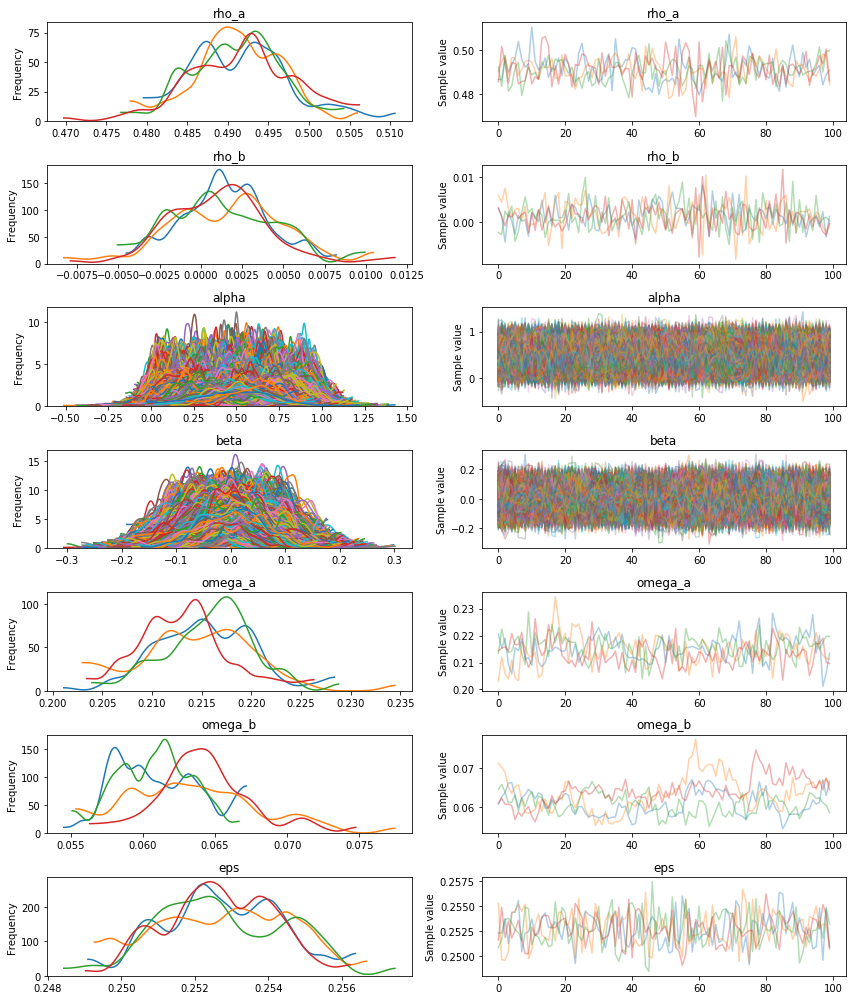

In [6]:
pm.traceplot(trace)
plt.show()

## Plot posterior mean values of parameters

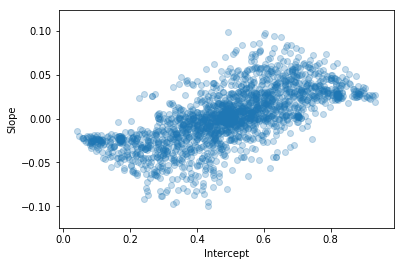

In [7]:
alpha_pm = np.mean(trace['alpha'], axis=0)
beta_pm = np.mean(trace['beta'], axis=0)
fig, axes = plt.subplots(1)
axes.scatter(alpha_pm, beta_pm, alpha=0.25)
axes.set_xlabel('Intercept')
axes.set_ylabel('Slope')
plt.show()

There is clearly some information here; a moderately high intercept is correlated with a positive slope (vice versa for low intercepts). However, the fact that opinions are constrained to $[0,1]$ means that very high intercepts can only have small positive slope as there's not much room left to update in. This could be used to improve inference if we were presented with a novel question where we have only quick judgements.

## Posterior mean predictions

In [8]:
num_samples = 1000

val_questions = test_data.question.unique()

targets = []
preds = []
for q_id in val_questions:
    val_q = test_data.loc[test_data.question == q_id]
    
    try:
        alpha_post = trace['alpha'][:, q_id]
        beta_post = trace['beta'][:, q_id]
    
        to_average = []
        for i in range(num_samples):
            alpha_sample = np.random.choice(alpha_post)
            beta_sample = np.random.choice(beta_post)
            to_average.append(np.clip(alpha_sample + beta_sample * 2, 0, 1))

        preds.append(np.mean(to_average))
        
    except IndexError:
        preds.append(0.5)
        
    targets.append(val_q.opinion.values[0])

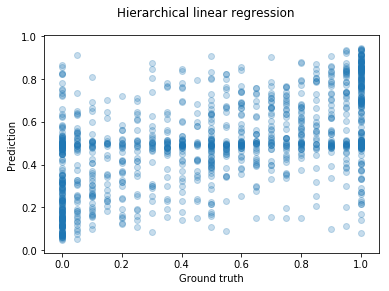

In [9]:
fig, axes = plt.subplots(1)
axes.scatter(targets, preds, alpha=0.25)
axes.set_xlabel('Ground truth')
axes.set_ylabel('Prediction')
fig.suptitle('Hierarchical linear regression')
plt.show()

In [10]:
preds = np.array(preds)
targets = np.array(targets)
square_errs = np.power((preds - targets), 2)
print('MSE = ', np.mean(square_errs))

MSE =  0.09814238748257287


So we're doing pretty well but not outstandingly - most of our gains come from predicting very high/low confidence questions well. There's a pretty clear noise floor if we ignore user identity, as the example below shows.

## Example plot

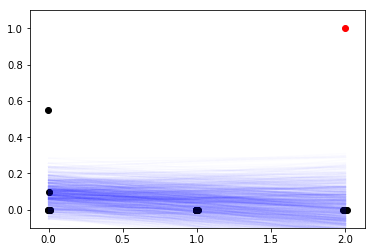

In [11]:
q_id = 1190 # 1190 or 634 are the 'worst' examples

fig, axes = plt.subplots(1)
axes.set_ylim([-0.1, 1.1])

alpha_post = trace['alpha'][:, q_id]
beta_post = trace['beta'][:, q_id]

for i in range(1000):
    alpha_sample = np.random.choice(alpha_post)
    beta_sample = np.random.choice(beta_post)
    x = np.linspace(0, 2)
    y = alpha_sample + beta_sample * x
    axes.plot(x,y, alpha=0.01, c='b')

q_specific = data.loc[data.question == q_id]
jitter = np.random.normal(0, 0.01, size=len(q_specific.time))
val_q_specific = val_data.loc[val_data.question == q_id]

axes.scatter(q_specific.time + jitter, q_specific.opinion, c='k')
axes.scatter(val_q_specific.time, val_q_specific.opinion, c='r')
plt.show()

Here we can see that the majority of the training data is completely different to the validation datapoint in a way we really can't hope to predict. It's possible that the highest quick judgement is from the same user as the validation datapoint, so that by using user id we might hope to have predicted a lower value. When we mask we will typically lose this information, however.

## MSE vs response count

In [12]:
num_samples = 100

val_questions = test_data.question.unique()

targets = []
preds = []
square_errs = []
num_train_points = []

for q_id in val_questions:
    train_q = data.loc[data.question == q_id]
    #print(q_id)
    #print(train_q)
    #print(len(train_q))
    val_q = test_data.loc[test_data.question == q_id]
    
    try:
        alpha_post = trace['alpha'][:, q_id]
        beta_post = trace['beta'][:, q_id]

        to_average = []
        for i in range(num_samples):
            alpha_sample = np.random.choice(alpha_post)
            beta_sample = np.random.choice(beta_post)
            to_average.append(np.clip(alpha_sample + beta_sample * 2, 0, 1))

        preds.append(np.mean(to_average))
        
    except IndexError:
        preds.append(0.5)
    
    targets.append(val_q.opinion.values[0])
    square_errs.append((preds[-1] - targets[-1])**2)
    num_train_points.append(len(train_q))

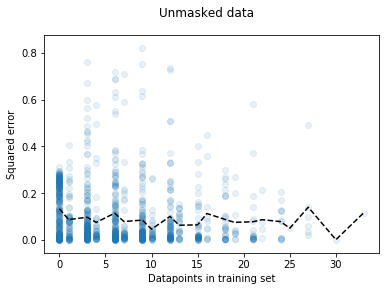

In [13]:
fig, axes = plt.subplots(1)
square_errs = np.array(square_errs)
axes.scatter(num_train_points, square_errs, alpha=0.1)

means = []
for i in np.unique(num_train_points):
    use_idx = np.argwhere(num_train_points == i).squeeze()
    means.append(np.mean(square_errs[use_idx]))
    
axes.plot(np.unique(num_train_points), means, c='k', ls='--')
axes.set_xlabel('Datapoints in training set')
axes.set_ylabel('Squared error')
fig.suptitle('Unmasked data')
    
plt.show()

## As above but with binning

/home/ryan/anaconda3/envs/psj-theano/lib/python3.5/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Computing the msd similarity matrix...
Done computing similarity matrix.


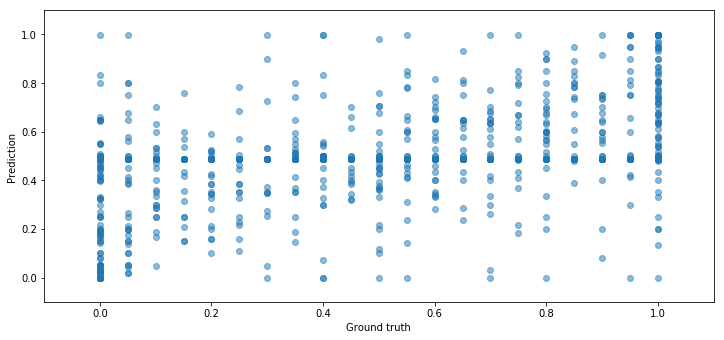

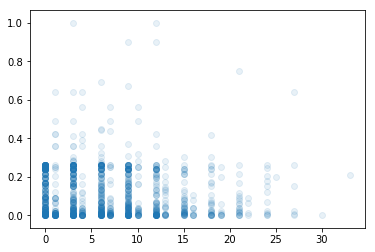

In [14]:
from importlib import reload
import src.demos.notebook_utils as nu
reload(nu)
#from src.demos.notebook_utils import run_baseline

train_flat = train_dataset.flatten()
val_flat = val_dataset.flatten()
test_flat = test_dataset.flatten()

baseline_alg_str = 'KNN'

fermi_unmasked = {'min_k':1,
                  'user_based': True,
                  'sim': 'MSD',
                  'k': 6}

fermi_light = {'min_k':1,
               'user_based': True,
               'sim': 'MSD',
               'k': 3}

fermi_heavy = {'min_k':1,
               'user_based': True,
               'sim': 'MSD',
               'k': 6}

pfact_unmasked = {'min_k':1,
                  'user_based': True,
                  'sim': 'pearson_baseline',
                  'k': 1}

pfact_light = {'min_k':1,
               'user_based': True,
               'sim': 'cosine',
               'k': 1}

pfact_heavy = {'min_k':1,
               'user_based': True,
               'sim': 'MSD',
               'k': 3}

cf_algo_params = fermi_heavy

ans = nu.run_baseline(train_flat, 
                      test_flat, 
                      baseline_alg_str, 
                      calibrate=True,
                      cf_algo_params=cf_algo_params)

train_loss, val_loss, val_ratings, val_pred, KNN_num_train_points = ans

KNN_square_errs = (val_pred - val_ratings)**2

fig, axes = plt.subplots(1)
axes.scatter(KNN_num_train_points, KNN_square_errs, alpha=0.1)

sim: MSD user_based: True k: 6 min_k: 1


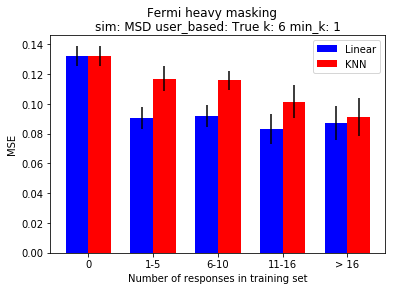

In [15]:
fig, axes = plt.subplots(1)

def make_bars(square_errs, num_train_points):
    heights = [[], [], [], [], []]

    for i, num_vals in enumerate(num_train_points):
        if num_vals == 0:
            heights[0].append(square_errs[i])

        elif (num_vals >= 1 and num_vals < 6):
            heights[1].append(square_errs[i])

        elif (num_vals >= 6 and num_vals < 11):
            heights[2].append(square_errs[i])

        elif (num_vals >= 11 and num_vals < 16):
            heights[3].append(square_errs[i])

        else:
            heights[4].append(square_errs[i])
    
    return heights

bar_width=0.35
points = np.array([0,1,2,3,4])

heights = make_bars(square_errs, num_train_points)
MSEs = [np.mean(i) for i in heights]
sems = [np.std(i)/np.sqrt(len(i)) for i in heights]
stds = [np.std(i) for i in heights]

KNN_heights = make_bars(KNN_square_errs, KNN_num_train_points)
KNN_MSEs = [np.mean(i) for i in KNN_heights]
KNN_sems = [np.std(i)/np.sqrt(len(i)) for i in KNN_heights]
KNN_stds = [np.std(i) for i in KNN_heights]

axes.bar(points, MSEs, bar_width, yerr=sems, color='b', label='Linear')
axes.bar(points + bar_width, KNN_MSEs, bar_width, yerr=KNN_sems, color='r', label='KNN')
axes.set_xticks(points + bar_width / 2)
axes.set_xticklabels(['0', '1-5', '6-10', '11-16', '> 16'])
axes.set_xlabel('Number of responses in training set')
axes.set_ylabel('MSE')
axes.legend()
fig.suptitle('Fermi heavy masking')

text = ['{}: {}'.format(i, cf_algo_params[i]) for i in cf_algo_params]
text = ' '.join(text)
print(text)
axes.set_title(text)
plt.show()

## Checking out anomalously high MSE questions

In [16]:
for i, num in enumerate(num_train_points):
    err = square_errs[i]
    
    if err > 0.5 and num > 20:
        print(i, num, err)
        q_id = val_questions[i]
        print('\nTraining samples')
        print(data.loc[data.question == q_id])
        print('\nTest samples')
        print(val_data.loc[val_data.question == q_id])

174 21 0.5819202039109389

Training samples
       opinion  question  time  user
220       0.30      1380     0     6
221       0.35      1380     1     6
222       0.00      1380     2     6
2661      0.40      1380     0    74
2662      0.00      1380     1    74
2663      0.00      1380     2    74
9795      0.25      1380     0   357
9796      0.40      1380     1   357
9797      0.05      1380     2   357
11790     0.75      1380     0   453
11791     0.85      1380     1   453
11792     1.00      1380     2   453
12548     0.75      1380     0   486
12549     0.00      1380     1   486
12550     0.00      1380     2   486
12925     0.25      1380     0   501
12926     0.00      1380     1   501
12927     0.00      1380     2   501
13239     0.50      1380     0   525
13240     0.15      1380     1   525
13241     0.10      1380     2   525

Test samples
Empty DataFrame
Columns: [opinion, question, time, user]
Index: []


In [17]:
question_id = 1100

for datum in val_dataset:
    if datum['item_id'] == question_id:
        print(datum)

{'item_id': 1100, 'rating': array([nan, nan,  0.]), 'user_id': 131, 'item_text': 'worldwide box office for Jurassic World in USD * Volume of a sphere with radius 1 units to nearest cubic unit * 98 - perimeter of a square with side length six < 1,920,000,000,000', 'item_metadata': array([0.])}
